In [3]:
import torch
from __future__ import absolute_import, division, print_function
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import GPy
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC
from matplotlib import pyplot
pyro.clear_param_store()
import time
torch.manual_seed(12)
pyro.set_rng_seed(101)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np 
import pods


In [4]:
import gpflow

In [5]:
np.random.seed(1)

In [6]:
data = pods.datasets.oil_100()

In [7]:
Y=data['X']
Q=5
M = 20  # number of inducing pts
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
Xu = torch.tensor(Z).float()

In [8]:
Y_t= torch.Tensor(Y.T)
#X_loc = torch.tensor(X_mean).float()
#Xu = torch.tensor(Z).float()
#Xu = torch.zeros(20, Q)
#X_loc = torch.zeros(Y.shape[0],Q)

In [9]:
def initialize_latent(input_dim, Y):
    Xr = np.asfortranarray(np.random.normal(0, 1, (Y.shape[0], input_dim)))
    p = GPy.util.pca.PCA(Y)
    PC = p.project(Y, min(input_dim, Y.shape[1]))
    Xr[:PC.shape[0], :PC.shape[1]] = PC
    var = .1*p.fracs[:input_dim]
    Xr -= Xr.mean(0)
    Xr /= Xr.std(0)
    return Xr, var/var.max()

In [11]:
Xr, fracs = initialize_latent(5, Y)
X_loc = torch.tensor(Xr).float()
X_variance = torch.tensor(np.random.uniform(0,.1,X_mean.shape)).float()
fracs = torch.tensor(1./fracs).float()
kernel = gp.kernels.RBF(input_dim=5, lengthscale=fracs)
gpmodel = gp.models.SparseGPRegression(X_loc, Y_t, kernel, Xu, noise=torch.tensor(0.5),approx='DTC')
gplvm = gp.models.GPLVM(gpmodel)

CPU+SystemTime:109.5 seconds
Code Run Time:117.2224473953247 seconds


Text(0.5,1,'Convergence of SVI')

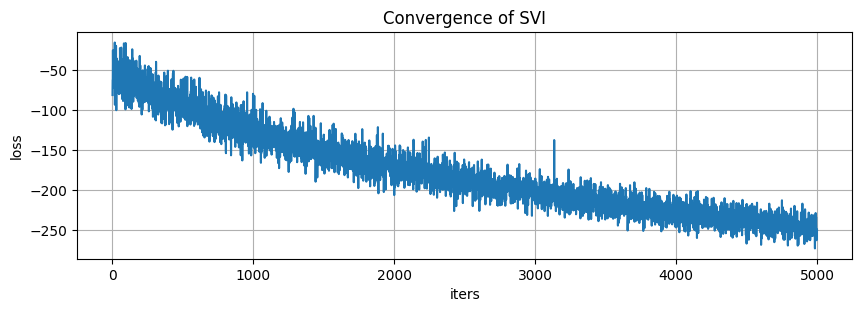

In [180]:
i=list(range(1,5001))
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=5000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI')

In [181]:
X = gplvm.get_param("X_loc")
X_var = gplvm.get_param("X_scale_tril")
Kfu = gplvm.base_model.kernel(X, gplvm.base_model.get_param('Xu')).detach().numpy()
Kuu = gplvm.base_model.kernel(gplvm.base_model.get_param('Xu'), gplvm.base_model.get_param('Xu')).detach().numpy()
Kuf = Kfu.T
print('Kfu shape'+str(Kfu.shape))
print('Kuu shape'+str(Kuu.shape))
print('Kuf shape'+str(Kuf.shape))
noise = gplvm.base_model.get_param('noise').detach().numpy()
K = np.dot(np.dot(Kfu,pdinv(Kuu)[0]),Kuf)  + np.eye(X.shape[0])*(1/noise)

Kfu shape(100, 20)
Kuu shape(20, 20)
Kuf shape(20, 100)


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


Text(0.5,1,'Bayesian GPLVM + SVI')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


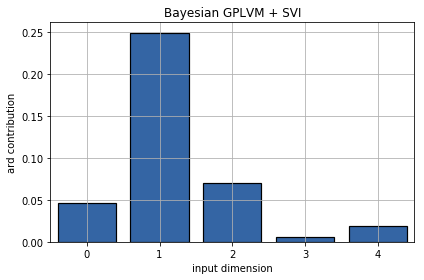

In [349]:
active = gplvm.base_model.kernel.active_dims
input_dim = gplvm.base_model.kernel.input_dim
Var = gplvm.base_model.kernel.get_param('variance').detach().numpy()
Len = gplvm.base_model.kernel.get_param('lengthscale').detach().numpy()
Co = GPy.kern.RBF(ARD=True,active_dims=active,input_dim=input_dim,lengthscale=Len,variance=Var)
Co.K = K
Co.plot_ARD()
plt.grid()
plt.title('Bayesian GPLVM + SVI')

Neearest neighbourboost size k =1 Continuity:0.9857142857142858
Neearest neighbourboost size k =5 Continuity:0.9780869565217392
Neearest neighbourboost size k =10 Continuity:0.9653846153846154
Neearest neighbourboost size k =15 Continuity:0.9582683982683983
Neearest neighbourboost size k =20 Continuity:0.947863309352518
Neearest neighbourboost size k =25 Continuity:0.9463870967741935
Neearest neighbourboost size k =30 Continuity:0.9425015290519878
Neearest neighbourboost size k =40 Continuity:0.9383354430379747
Neearest neighbourboost size k =45 Continuity:0.9291805555555556
Neearest neighbourboost size k =50 Continuity:0.9116408163265306
Neearest neighbourboost size k =55 Continuity:0.8857373737373737
Neearest neighbourboost size k =60 Continuity:0.8522435897435897
Neearest neighbourboost size k =75 Continuity:0.7463


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

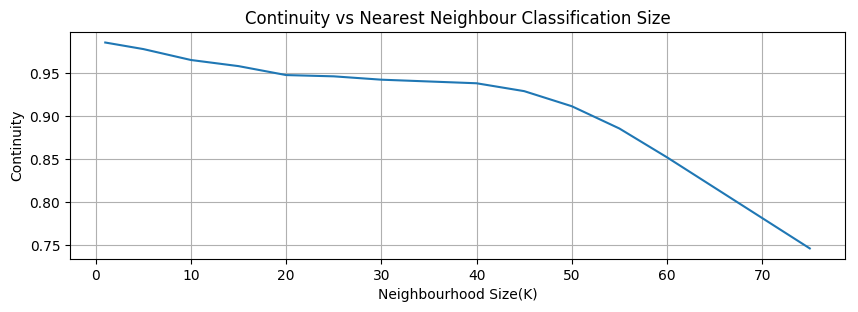

In [184]:
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9881632653061224
Neearest neighbourboost size k =5 Trust:0.9789782608695652
Neearest neighbourboost size k =10 Trust:0.969585798816568
Neearest neighbourboost size k =15 Trust:0.9605108225108225
Neearest neighbourboost size k =20 Trust:0.9516762589928057
Neearest neighbourboost size k =25 Trust:0.9484451612903226
Neearest neighbourboost size k =30 Trust:0.9481834862385321
Neearest neighbourboost size k =40 Trust:0.9411139240506329
Neearest neighbourboost size k =45 Trust:0.9327013888888889
Neearest neighbourboost size k =50 Trust:0.9174367346938775
Neearest neighbourboost size k =55 Trust:0.8931414141414141
Neearest neighbourboost size k =60 Trust:0.8651538461538462
Neearest neighbourboost size k =75 Trust:0.7516


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

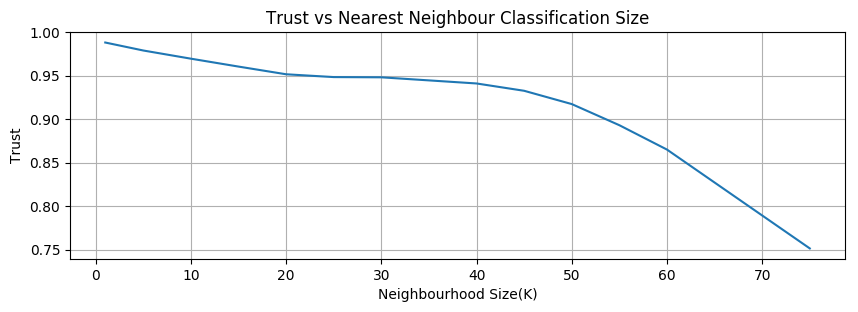

In [185]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

## Bayesian GPLVM

In [21]:
m = GPy.models.BayesianGPLVM(Y,Z=Z, input_dim= 5,  init="PCA",num_inducing=20,stochastic=False)
m.data_labels = Y.argmax(axis=1)
loss2 = m.optimize('bfgs', messages=1,max_iters=10000) #scg', 'lbfgs', 'tnc'
##m.optimize?

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


Text(0.5,1,'Bayesian GPLVM- DTC')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


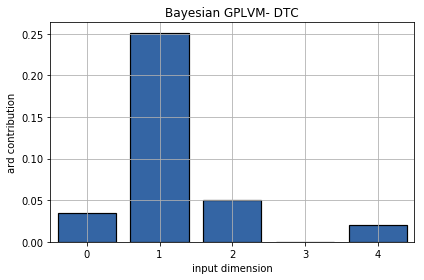

In [347]:
m.kern.plot_ARD()
plt.grid()
plt.title('Bayesian GPLVM- DTC')

In [23]:
Kfu2 =  m.kern.K(m.X.mean, m.Z)
Kuu2 = m.kern.K(m.Z, m.Z)
Kuf2 = Kfu2.T 
print('Kfu shape'+str(Kfu2.shape))
print('Kuu shape'+str(Kuu2.shape))
print('Kuf shape'+str(Kuf2.shape))

Kfu shape(100, 20)
Kuu shape(20, 20)
Kuf shape(20, 100)


In [24]:
Kff = np.dot(np.dot(Kfu2,pdinv(Kuu2)[0]),Kuf2)

Kff = Kff + np.eye(m.X.mean.shape[0])*(1/m.Gaussian_noise.variance)

In [186]:
Samples=1000
VS = [] # Vector Containing Matrix Samples (Xs)
for i in range(Samples):
    VS.append(pyro.sample('Variational Distibtuion',dist.MultivariateNormal(gplvm.get_param("X_loc"), scale_tril=gplvm.get_param("X_scale_tril")).independent(gplvm.get_param("X_loc").dim()-1),))

In [ ]:
def Joint_Prob2(Y,Xs,N,D,Q,m,K_new):
    Kfu2 =  m.kern.K(Xs.detach().numpy(), m.Z)
    Kuu2 =  m.kern.K(m.Z, m.Z)
    Kuf2 =  Kfu2.T
    Kff = np.dot(np.dot(Kfu2,pdinv(Kuu2)[0]),Kuf2)
    K_new = Kff + np.eye(m.X.mean.shape[0])*(1/m.Gaussian_noise.variance)
    K_inv = np.linalg.inv(K_new) # PNN inverse of KNN
    Xs = Xs.detach().numpy()
    Prob = -N*D*0.5*np.log(2*np.pi) - D/2*np.log(np.linalg.det(K_new))-1/2*np.trace(np.matmul(np.matmul(Y.T,K_inv),Y)) - (N*Q/2)*np.log(2*np.pi)-0.5*np.trace(np.matmul(Xs,Xs.T))
    return Prob


In [187]:
def Joint_Prob(Y,Xs,N,D,Q,m,K_new):
    K_inv = np.linalg.inv(K_new)
    Prob = -N*D*0.5*np.log(2*np.pi) - D/2*np.log(np.linalg.det(K_new))-1/2*np.trace(np.matmul(np.matmul(Y.T,K_inv),Y)) - (N*Q/2)*np.log(2*np.pi)-0.5*np.trace(np.matmul(Xs,Xs.T))
    return Prob 

In [188]:
N= Y.shape[0]
Q = 5
D=12
Join = []
for sample in VS:
    Join.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))
    #Join.append(Joint_Prob2(Y,sample.detach().numpy(),N,D,Q,m,Kff))

In [189]:
def var(VS,Q,K,gplvm):
    pdf1 = 0
    qx = []
    temp=gplvm.get_param('X_loc').detach().numpy()
    for j in range(len(VS)):
        for i in range(Q):
            pdf1 = pdf1+ np.log(stats.multivariate_normal(temp[:,i],K).pdf(VS[j].detach().numpy()[:,i]))
        qx.append(pdf1)
        pdf1=0
    return qx

In [190]:
def Var(X,gplvm,D,K_new):
    #Kfu = gplvm.base_model.kernel(X, gplvm.base_model.get_param('Xu')).detach().numpy()
    #Kuu = gplvm.base_model.kernel(gplvm.base_model.get_param('Xu'), gplvm.base_model.get_param('Xu')).detach().numpy()
    #Kuf = Kfu.T
    #noise = gplvm.base_model.get_param('noise').detach().numpy()
    #K_new = np.dot(np.dot(Kfu,pdinv(Kuu)[0]),Kuf)  + np.eye(X.shape[0])*(1/noise)
    
    K_inv = pdinv(K_new)[0]
    temp = np.matmul(np.matmul(X.detach().numpy().T,K_inv),X.detach().numpy()) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [191]:
qx2 = var(VS,Q,K,gplvm)

In [192]:
qx = []
for sample in VS:
    qx.append(Var(sample,gplvm=gplvm,D=Q,K_new=K))

In [193]:
Rs,Rs2 = log_Ratios(qx,Join)

In [196]:
Rs=[]
S = len(Rs2)
for i in Rs2:
    Rs.append(i/S)
print('K:'+ str(psisloo(-1*np.array(Rs)))) 

In [206]:
print('K:'+ str(psisloo(-1*np.array(Rs)))) 

K:(3.347050008149188, 3.347050008149188, 0.04872829583071613)


Text(0.5,1.05,'Bayesian GPLVM-DTC')

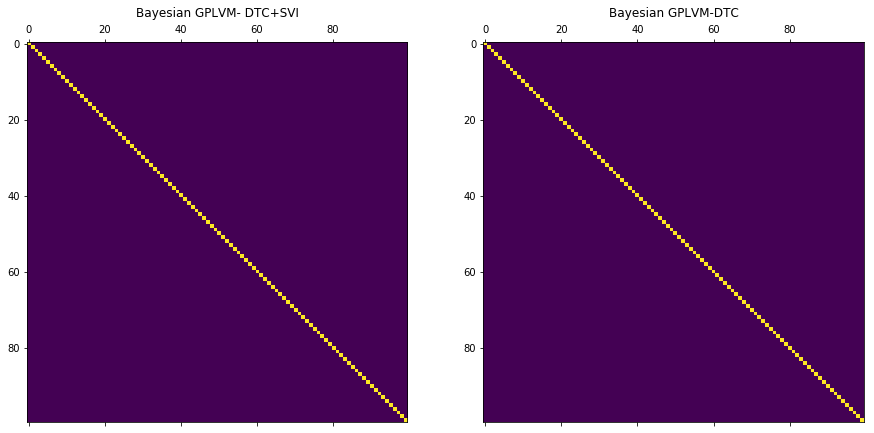

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].matshow(K)
ax[0].set_title('Bayesian GPLVM- DTC+SVI')
ax[1].matshow(Kff)
ax[1].set_title('Bayesian GPLVM-DTC')

Neearest neighbourboost size k =1 Continuity:0.986938775510204
Neearest neighbourboost size k =5 Continuity:0.9788043478260869
Neearest neighbourboost size k =10 Continuity:0.9689467455621302
Neearest neighbourboost size k =15 Continuity:0.9613939393939394
Neearest neighbourboost size k =20 Continuity:0.9581079136690648
Neearest neighbourboost size k =25 Continuity:0.9560645161290322
Neearest neighbourboost size k =30 Continuity:0.9528990825688073
Neearest neighbourboost size k =40 Continuity:0.9550189873417722
Neearest neighbourboost size k =45 Continuity:0.9537847222222222
Neearest neighbourboost size k =50 Continuity:0.9481632653061225
Neearest neighbourboost size k =55 Continuity:0.9354141414141414
Neearest neighbourboost size k =60 Continuity:0.9176410256410257
Neearest neighbourboost size k =75 Continuity:0.8231666666666666


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

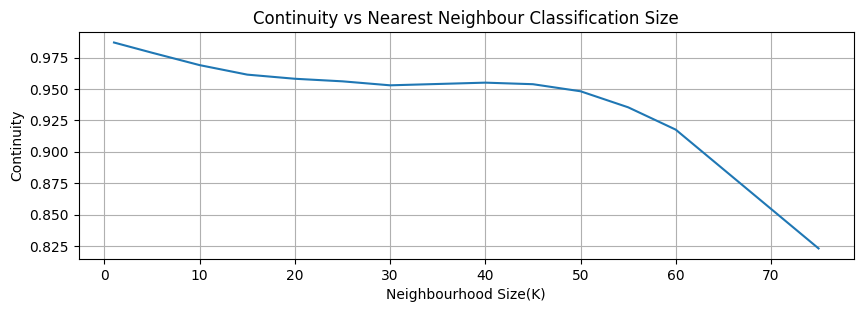

In [203]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9478571428571428
Neearest neighbourboost size k =5 Trust:0.9264130434782609
Neearest neighbourboost size k =10 Trust:0.9198224852071006
Neearest neighbourboost size k =15 Trust:0.9270129870129871
Neearest neighbourboost size k =20 Trust:0.9287985611510792
Neearest neighbourboost size k =25 Trust:0.9258903225806452
Neearest neighbourboost size k =30 Trust:0.9264464831804281
Neearest neighbourboost size k =40 Trust:0.9353924050632911
Neearest neighbourboost size k =45 Trust:0.9353263888888889
Neearest neighbourboost size k =50 Trust:0.9289877551020408
Neearest neighbourboost size k =55 Trust:0.922060606060606
Neearest neighbourboost size k =60 Trust:0.908551282051282
Neearest neighbourboost size k =75 Trust:0.7898666666666667


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

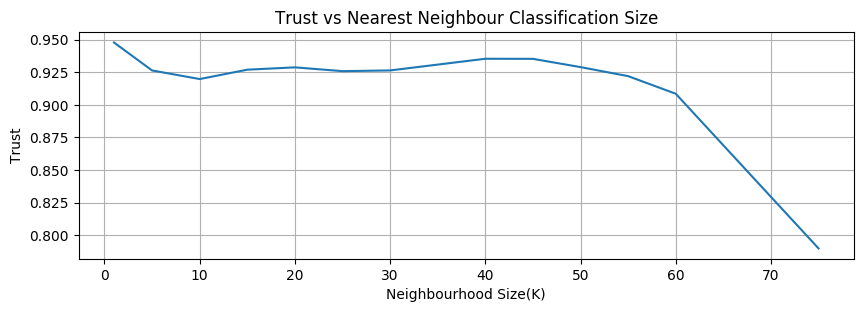

In [204]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# GPLVM

In [12]:
kernel = GPy.kern.RBF(5, ARD=True,lengthscale=fracs.detach().numpy()) 
m2 = GPy.models.GPLVM(Y, input_dim= 5 ,kernel=kernel)
m2.data_labels = Y.argmax(axis=1)
loss3 = m2.optimize('lbfgs', messages=1,max_iters=15000) #scg', 'lbfgs', 'tnc'


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


Text(0.5,1,'GPLVM-MAP')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


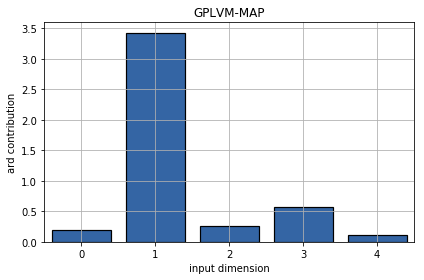

In [13]:
m2.kern.plot_ARD()
plt.grid()
plt.title('GPLVM-MAP')

In [14]:
m2.Gaussian_noise[0]

3.4001403370769597e-09

In [15]:
K_g = m2.kern.K(m2.X,m2.X)+np.eye(m2.X.shape[0])*(1/m2.Gaussian_noise.variance)

Text(0.5,1.05,'GPLVM-MAP')

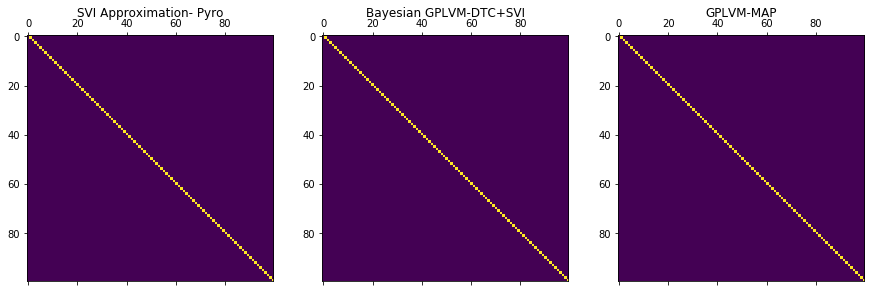

In [218]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].matshow(K)
ax[0].set_title('SVI Approximation- Pyro')
ax[1].matshow(Kff)
ax[1].set_title('Bayesian GPLVM-DTC+SVI')
ax[2].matshow(K_g)
ax[2].set_title('GPLVM-MAP')

Neearest neighbourboost size k =1 Continuity:0.9526530612244898
Neearest neighbourboost size k =5 Continuity:0.9268695652173913
Neearest neighbourboost size k =10 Continuity:0.8960828402366864
Neearest neighbourboost size k =15 Continuity:0.8665627705627705
Neearest neighbourboost size k =20 Continuity:0.8406043165467626
Neearest neighbourboost size k =25 Continuity:0.8209870967741936
Neearest neighbourboost size k =30 Continuity:0.7988929663608563
Neearest neighbourboost size k =40 Continuity:0.7656455696202531
Neearest neighbourboost size k =45 Continuity:0.7453125
Neearest neighbourboost size k =50 Continuity:0.7158448979591837
Neearest neighbourboost size k =55 Continuity:0.6745656565656566
Neearest neighbourboost size k =60 Continuity:0.6307051282051283
Neearest neighbourboost size k =75 Continuity:0.4895666666666666


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

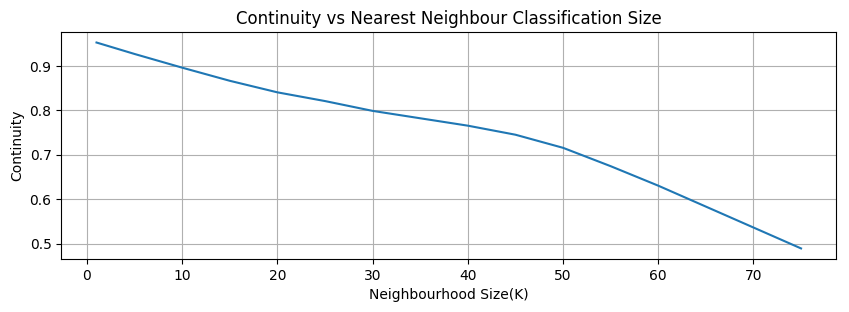

In [30]:
dd_orig = distance_matrix(Y)
t = np.array(m2.X)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9692857142857143
Neearest neighbourboost size k =5 Trust:0.9277608695652174
Neearest neighbourboost size k =10 Trust:0.9059171597633136
Neearest neighbourboost size k =15 Trust:0.8873160173160173
Neearest neighbourboost size k =20 Trust:0.8700071942446044
Neearest neighbourboost size k =25 Trust:0.8561741935483871
Neearest neighbourboost size k =30 Trust:0.8399877675840979
Neearest neighbourboost size k =40 Trust:0.7867215189873418
Neearest neighbourboost size k =45 Trust:0.7581111111111111
Neearest neighbourboost size k =50 Trust:0.7221877551020408
Neearest neighbourboost size k =55 Trust:0.6766767676767677
Neearest neighbourboost size k =60 Trust:0.6280897435897437
Neearest neighbourboost size k =75 Trust:0.4863333333333333


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

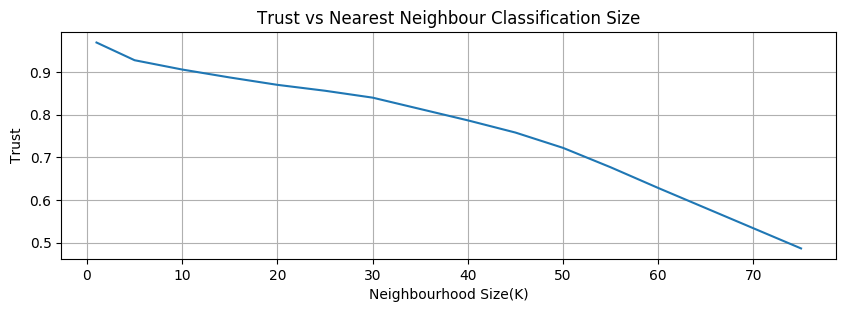

In [31]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [32]:
cov = kernel.K(m2.X,m2.X)+np.eye(m2.X.shape[0])*(1/m2.Gaussian_noise[0])
#np.linalg.det(cov)
#cov

In [33]:
samples = []
for i in range(1000):
    samples.append(np.stack(arrays=[np.random.multivariate_normal(m2.X[:,0],cov),
                 np.random.multivariate_normal(m2.X[:,1],cov),
                 np.random.multivariate_normal(m2.X[:,2],cov),
                 np.random.multivariate_normal(m2.X[:,3],cov),
                 np.random.multivariate_normal(m2.X[:,4],cov)]
                 ,axis=1))

 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:covariance is not symmetric positive-semidefinite.
 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:covariance is not symmetric positive-semidefinite.
 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:covariance is not symmetric positive-semidefinite.
 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:covariance is not symmetric positive-semidefinite.
 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:covariance is not symmetric positive-semidefinite.


In [328]:
samples[0].shape

(100, 5)

In [334]:
Join2=[]
for Xs in samples:
    Join2.append(Joint_Prob(Y=Y,Xs=Xs,N=100,D=12,Q=5,m=m2,K_new=Kff))
  

In [ ]:
print('K:'+ str(psisloo(-1*np.array(Rs))))

In [339]:
qx = var2(samples,Q=5,K=cov,m=m2)

 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:divide by zero encountered in log


In [345]:

#plt.xlabel('X')
#plt.ylabel('PDF(X)')

In [338]:
def var2(VS,Q,K,m):
    pdf1 = 0
    qx = []
    temp=m.X
    for j in range(len(VS)):
        for i in range(Q):
            pdf1 = pdf1+ np.log(stats.multivariate_normal(temp[:,i],K).pdf(VS[j][:,i]))
        qx.append(pdf1)
        pdf1=0
    return qx

# Markov Chain Monte Carlo

In [34]:
from __future__ import print_function
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

In [35]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
k = (kernels.RBF(5, ARD=True))
m4 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)

In [36]:
m4.likelihood.variance= 0.00390268

In [37]:
m4.compile()
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m4, maxiter=15) # start near MAP

In [38]:
s = gpflow.train.HMC()
samples = s.sample(m4, 1000, epsilon=0.12, lmax=20, lmin=5, thin=5, logprobs=True)

In [39]:
X_loc = np.average(samples['BayesianGPLVM/X_mean'], axis=0)
X_var = np.average(samples['BayesianGPLVM/X_var'], axis=0)
log_prob = samples.logprobs

Neearest neighbourboost size k =1 Continuity:0.9929591836734694
Neearest neighbourboost size k =5 Continuity:0.9909347826086956
Neearest neighbourboost size k =10 Continuity:0.993112426035503
Neearest neighbourboost size k =15 Continuity:0.9930476190476191
Neearest neighbourboost size k =20 Continuity:0.9939280575539569
Neearest neighbourboost size k =25 Continuity:0.9915677419354839
Neearest neighbourboost size k =30 Continuity:0.9908012232415903
Neearest neighbourboost size k =40 Continuity:0.9897088607594937
Neearest neighbourboost size k =45 Continuity:0.99
Neearest neighbourboost size k =50 Continuity:0.9886938775510205
Neearest neighbourboost size k =55 Continuity:0.9872323232323232
Neearest neighbourboost size k =60 Continuity:0.9843846153846154
Neearest neighbourboost size k =75 Continuity:0.9156666666666666


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

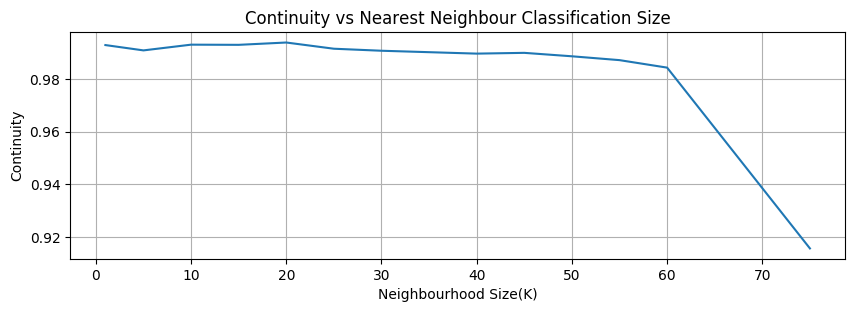

In [40]:
t = np.array(X_loc)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.991938775510204
Neearest neighbourboost size k =5 Trust:0.9902826086956522
Neearest neighbourboost size k =10 Trust:0.9911715976331361
Neearest neighbourboost size k =15 Trust:0.9929350649350649
Neearest neighbourboost size k =20 Trust:0.9926618705035971
Neearest neighbourboost size k =25 Trust:0.9912
Neearest neighbourboost size k =30 Trust:0.9901712538226299
Neearest neighbourboost size k =40 Trust:0.9914556962025316
Neearest neighbourboost size k =45 Trust:0.9919305555555555
Neearest neighbourboost size k =50 Trust:0.989534693877551
Neearest neighbourboost size k =55 Trust:0.9891515151515151
Neearest neighbourboost size k =60 Trust:0.9852051282051282
Neearest neighbourboost size k =75 Trust:0.9292


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

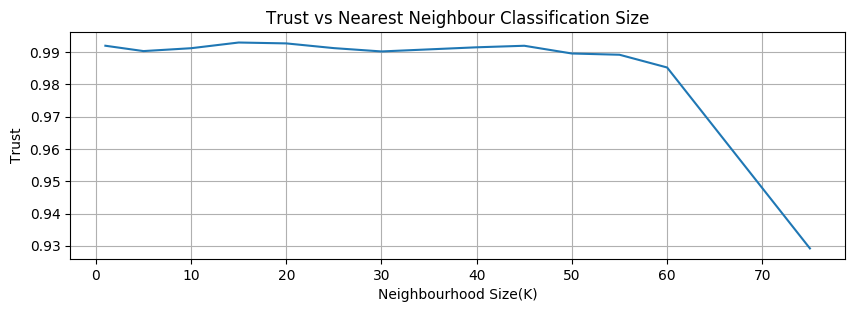

In [276]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [289]:
N= Y.shape[0]
Q = 5
D=12
Join = []
for sample in range(1000):
    Join.append(Joint_Prob(Y,samples['BayesianGPLVM/X_mean'][i],N,D,Q,m,Kff))

In [290]:
Rs,Rs2 = log_Ratios(list(log_prob),Join)

 /home/aneeqr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:overflow encountered in exp


In [293]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(19392.147538145204, 19392.147538145204, inf)


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


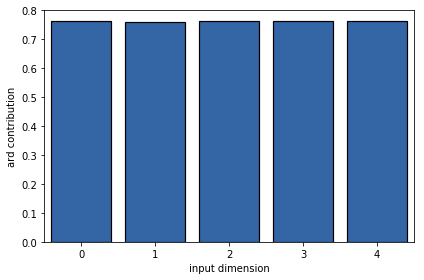

In [44]:
Len  = np.average(samples['BayesianGPLVM/kern/lengthscales'])
Var = np.average(samples['BayesianGPLVM/kern/variance'])
Co2 = GPy.kern.RBF(ARD=True,input_dim=5,lengthscale=Len,variance=Var)
noise = np.average(samples['BayesianGPLVM/likelihood/variance'])
K_mcmc = Co2.K(X_loc) + np.eye(X_loc.shape[0])*(1/noise)
Co2.plot_ARD()

In [306]:
samples = []
for i in range(1000):
    samples.append(np.stack(arrays=[np.random.multivariate_normal(X_loc[:,0],K_mcmc),
                 np.random.multivariate_normal(X_loc[:,0],K_mcmc),
                 np.random.multivariate_normal(X_loc[:,1],K_mcmc),
                 np.random.multivariate_normal(X_loc[:,2],K_mcmc),
                 np.random.multivariate_normal(X_loc[:,3],K_mcmc)]
                 ,axis=1))

In [307]:
N= Y.shape[0]
Q = 5
D=12
Join = []
for sample in samples:
    Join.append(Joint_Prob(Y,sample,N,D,Q,m,Kff))

In [309]:
def Var2(X,D,K_new):   
    K_inv = pdinv(K_new)[0]
    temp = np.matmul(np.matmul(X.T,K_inv),X) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [310]:
qx = []
for sample in samples:
    qx.append(Var2(sample,D=Q,K_new=K_mcmc))

In [316]:
Rs,Rs2=log_Ratios(qx,Join)

In [320]:
Rs=[]
S = len(Rs2)
for i in Rs2:
    Rs.append(i/S)


In [323]:
print('K:'+ str(psisloo(-1*np.array(Rs))))

K:(54.097908490911685, 54.097908490911685, 0.8082421199291074)


In [2]:
fig, ax = plt.subplots(1, 4, figsize=(17, 11))
ax[0].matshow(K)
ax[0].set_title('SVI Approximation- Pyro')
ax[1].matshow(Kff)
ax[1].set_title('Bayesian GPLVM-DTC+SVI')
ax[2].matshow(K_g)
ax[2].set_title('GPLVM-MAP')
ax[3].matshow(K_mcmc)
ax[3].set_title('MCMC')
plt.subplots_adjust(bottom=0.8, right=2, top=17)

NameError: name 'plt' is not defined

In [22]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x

In [23]:
def log_Ratios(qx,Join):
    Rs = [] # Rations with exp
    Rs2 = [] # Rations without exp just log ratios
    for i in range(len(qx)):
        Rs.append(np.exp(Join[i]-qx[i]))
        Rs2.append(1*(Join[i]-qx[i]))
    return Rs,Rs2

In [25]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s